# Homework 3 - Ames Housing Dataset

Submitted By: Hardik Singh Negi SBU ID: 111886786

For all parts below, answer all parts as shown in the Google document for Homework 3. Be sure to include both code that justifies your answer as well as text to answer the questions. We also ask that code be commented to make it easier to follow.

In [313]:
#import all the necessary modules
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn.manifold import TSNE
from lightgbm import LGBMRegressor
from IPython.display import display
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import fclusterdata
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import permutation_test_score


warnings.filterwarnings('ignore')

#path constants (change these to load dataset in your own machine)
TRAIN_CSV = "/Users/hardik/Desktop/CSE-519/HW3/house-prices-advanced-regression-techniques/train.csv"
TEST_CSV = "/Users/hardik/Desktop/CSE-519/HW3/house-prices-advanced-regression-techniques/test.csv"

In [314]:
#Reference: Reused from my HW2 submission (cse519_hw2_Negi_HardikSingh_111886786.ipynb)
#Class to handle dataframe operations
class DataFrame_Hdl(object):
    def __init__(self, pd):
        self.pd = pd
    
    def read_from_csv(self, path):
        print("Reading Data from: " + path)
        return self.pd.read_csv(path)
    
    def write_to_csv(self,df,path):
        print("Writing Data to: " + path)
        df.to_csv(path, index = False)
    
    def merge_dataframe(self, left_df, right_df, on_field, m_type):
        print("Merging the Dataframes")
        temp_df = self.pd.merge(left_df, right_df, on=on_field, how=m_type)
        print("Dataframes Merged")
        return temp_df

In [315]:
df_hdl = DataFrame_Hdl(pd)

In [316]:
train_df = df_hdl.read_from_csv(TRAIN_CSV)

Reading Data from: /Users/hardik/Desktop/CSE-519/HW3/house-prices-advanced-regression-techniques/train.csv


In [317]:
#Reference: Reused from my HW2 submission (cse519_hw2_Negi_HardikSingh_111886786.ipynb)
def pretty_display_df(df, df_name, head_val):
        print(df_name + " Dataframe Shape:"+str(df.shape))
        display(df.head(head_val))

In [318]:
pretty_display_df(train_df, "Training Dataset", 10)

Training Dataset Dataframe Shape:(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [319]:
#Reference: Reused from my HW2 submission (cse519_hw2_Negi_HardikSingh_111886786.ipynb)
#Reference percentage of NAN values: https://stackoverflow.com/a/26266451/5512174
def dataframe_analysis(df, desc_cols, df_name):
        print ("Percentage of NAN values in the "+df_name+" dataset:")
        display(df.isna().sum().transform(lambda x: x/len(df) * 100))
        print ("Data type values in the "+ df_name +" dataset:")
        display(df.dtypes)
        print ("Description of "+ df_name +" dataset:")
        display(df[desc_cols].describe())

In [320]:
dataframe_analysis(train_df, train_df.columns, "Training")

Percentage of NAN values in the Training dataset:


Id                0.000000
MSSubClass        0.000000
MSZoning          0.000000
LotFrontage      17.739726
LotArea           0.000000
Street            0.000000
Alley            93.767123
LotShape          0.000000
LandContour       0.000000
Utilities         0.000000
LotConfig         0.000000
LandSlope         0.000000
Neighborhood      0.000000
Condition1        0.000000
Condition2        0.000000
BldgType          0.000000
HouseStyle        0.000000
OverallQual       0.000000
OverallCond       0.000000
YearBuilt         0.000000
YearRemodAdd      0.000000
RoofStyle         0.000000
RoofMatl          0.000000
Exterior1st       0.000000
Exterior2nd       0.000000
MasVnrType        0.547945
MasVnrArea        0.547945
ExterQual         0.000000
ExterCond         0.000000
Foundation        0.000000
                   ...    
BedroomAbvGr      0.000000
KitchenAbvGr      0.000000
KitchenQual       0.000000
TotRmsAbvGrd      0.000000
Functional        0.000000
Fireplaces        0.000000
F

Data type values in the Training dataset:


Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


Description of Training dataset:


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Part 1 - Pairwise Correlations

In [321]:
#Copying the dataset for paiwise correlation analysis.
ftr_df = train_df.copy()
num_cols = ftr_df._get_numeric_data().columns.tolist()

num_ftr_df = ftr_df[num_cols]
pretty_display_df(num_ftr_df, 'Numerical Ftrs', 10)

Numerical Ftrs Dataframe Shape:(1460, 38)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000
5,6,50,85.0,14115,5,5,1993,1995,0.0,732,...,40,30,0,320,0,0,700,10,2009,143000
6,7,20,75.0,10084,8,5,2004,2005,186.0,1369,...,255,57,0,0,0,0,0,8,2007,307000
7,8,60,NaN,10382,7,6,1973,1973,240.0,859,...,235,204,228,0,0,0,350,11,2009,200000
8,9,50,51.0,6120,7,5,1931,1950,0.0,0,...,90,0,205,0,0,0,0,4,2008,129900
9,10,190,50.0,7420,5,6,1939,1950,0.0,851,...,0,4,0,0,0,0,0,1,2008,118000


- This is dataframe of numerical columns only as the first step in finding the interesting features is to find the features with continuous values that have strong negative correlations.
- So in the next block I have made a heatmap of all the numerical features to find such pairs and avoided all the categorical features for now.

In [322]:
sb.set(style="darkgrid")

The heatmap visualized here contains all of the numeric variables and is NOT the FINAL heatmap for this part. I have used this heatmap to find interesting correlations among variables for the final result.

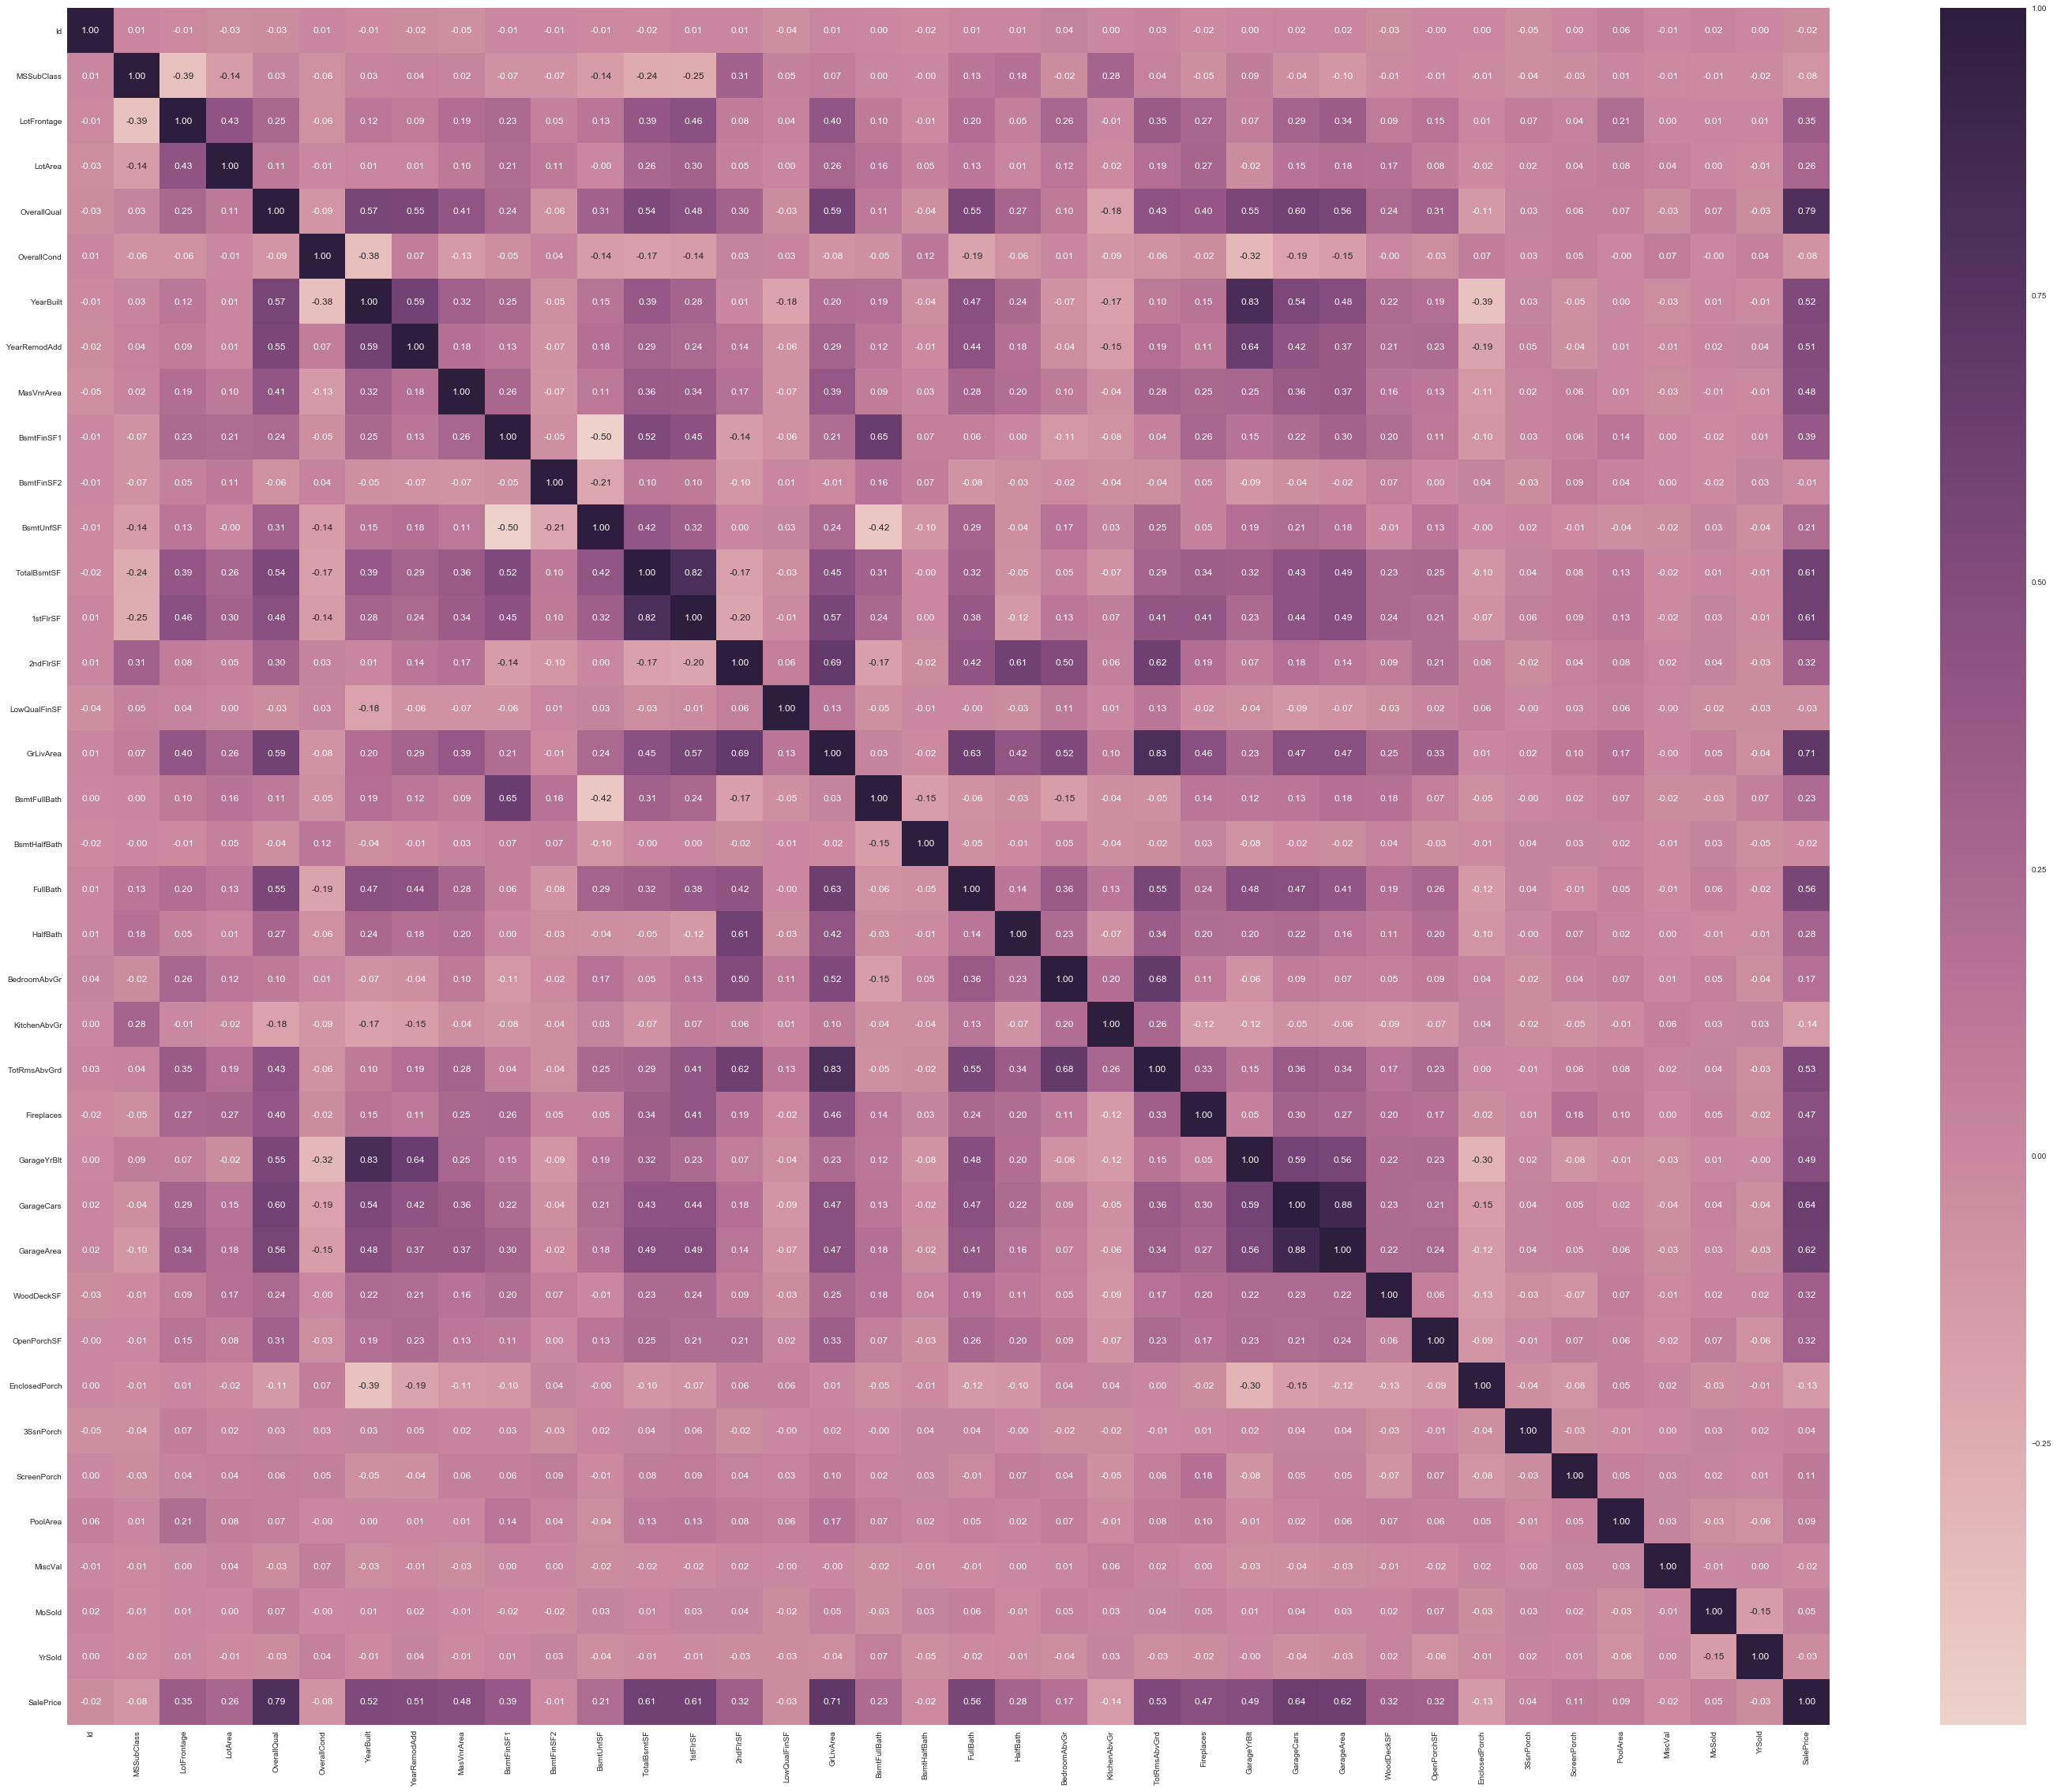

In [323]:
#Reference for heatmap: https://seaborn.pydata.org/generated/seaborn.heatmap.html
_, ax = plt.subplots(figsize=(50,40))  
sb.heatmap(ftr_df.corr(), annot=True, fmt=".2f", cmap=sb.cubehelix_palette(300), ax=ax)

From the given heatmap above and the correlation calculation displayed below it is fairly certain that the following feature pairs have a higly negative correlation:

1. BsmntUnfSF and BsmtFinSF1
2. OverallCond and YearBuilt
3. YearBuilt and EnclosedPorch
4. BsmtFullBath and BsmtUnfSF


In [324]:
print(ftr_df['BsmtUnfSF'].corr(ftr_df['BsmtFinSF1']))

-0.4952514692570121


In [325]:
print(ftr_df['OverallCond'].corr(ftr_df['YearBuilt']))

-0.3759831956069898


In [326]:
print(ftr_df['YearBuilt'].corr(ftr_df['EnclosedPorch']))

-0.38726778292807795


In [327]:
print(ftr_df['BsmtFullBath'].corr(ftr_df['BsmtUnfSF']))

-0.4229004773832128


Now, after identifying few interesting variables, I moved onto the full dataset so that I can identify other interesting features for the Part 1. Initial process required LabelEncoding to encode categorical features.

In [328]:
#Reference for Label Encoder to handle Nan values: https://stackoverflow.com/a/46406995/5512174
for ftr in ftr_df.columns:
    if ftr not in num_cols:
        #Here the label encoder encodes categorical data with numeric values and also handle Nan values
        ftr_df[ftr] = preprocessing.LabelEncoder().fit_transform(ftr_df[ftr].astype(str))


In [329]:
pretty_display_df(ftr_df, "Encoded Feature", 10)

Encoded Feature Dataframe Shape:(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,2,3,3,0,...,0,3,4,4,0,2,2008,8,4,208500
1,2,20,3,80.0,9600,1,2,3,3,0,...,0,3,4,4,0,5,2007,8,4,181500
2,3,60,3,68.0,11250,1,2,0,3,0,...,0,3,4,4,0,9,2008,8,4,223500
3,4,70,3,60.0,9550,1,2,0,3,0,...,0,3,4,4,0,2,2006,8,0,140000
4,5,60,3,84.0,14260,1,2,0,3,0,...,0,3,4,4,0,12,2008,8,4,250000
5,6,50,3,85.0,14115,1,2,0,3,0,...,0,3,2,2,700,10,2009,8,4,143000
6,7,20,3,75.0,10084,1,2,3,3,0,...,0,3,4,4,0,8,2007,8,4,307000
7,8,60,3,NaN,10382,1,2,0,3,0,...,0,3,4,2,350,11,2009,8,4,200000
8,9,50,4,51.0,6120,1,2,3,3,0,...,0,3,4,4,0,4,2008,8,0,129900
9,10,190,3,50.0,7420,1,2,3,3,0,...,0,3,4,4,0,1,2008,8,4,118000


Now as the main task of the assignment is to predict SalePrice, I have decided to select the features that exhibit high negative as well as positive correlation with SalePrice.

In [330]:
ftr_corr_var = ftr_df.corr()
ftr_corr_var = ftr_corr_var[['SalePrice']]

In [331]:
display(ftr_corr_var.nlargest(10, 'SalePrice'))

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


In [332]:
display(ftr_corr_var.nsmallest(10, 'SalePrice'))

,SalePrice
ExterQual,-0.636884
BsmtQual,-0.620886
KitchenQual,-0.589189
GarageFinish,-0.549247
FireplaceQu,-0.459605
GarageType,-0.415283
HeatingQC,-0.400178
BsmtExposure,-0.309043
LotShape,-0.255580
MSZoning,-0.166872


In the above section I have listed the features with high absolute correlation (irrespective of it being positive or negative) with SalePrice. After this I have taken a set of features from the analysis done till now as a shown in the following section. These features were selected to incorporate features with highly negative correlation (as shown earlier) and features with highly positive correlations.

In [333]:
corr_var_list = ['OverallQual', 'YearBuilt', 'ExterQual', 'BsmtQual', 'TotalBsmtSF', '1stFlrSF', 
     'GrLivArea', 'KitchenQual', 'GarageCars', 'GarageArea', 'SalePrice','BsmtUnfSF', 
     'BsmtFinSF1', 'OverallCond', 'EnclosedPorch', 'BsmtFullBath']
print(len(corr_var_list))

16


In [334]:
ftr_corr_df = train_df[corr_var_list]

Now, before extracting correlations among these variables I have fixed the encoding of the categorical variables by assigning an integer according to the ranking of the category in the following sections. This will show true correlations among the features

In [335]:
encoding_dict = {
                    'Ex' : 5,
                    'Gd' : 4,
                    'TA' : 3,
                    'Fa' : 2,
                    'Po' : 1
                }

In [336]:
#Reference: Reused from my HW2 submission (cse519_hw2_Negi_HardikSingh_111886786.ipynb)
def encode_df(df, q_dict, ftr_list):
    for ftr in ftr_list:
        df[ftr] = df[ftr].transform(lambda x: 0 if (x not in q_dict.keys()) else q_dict[x])
    
    return df

In [337]:
interesting_df = encode_df(ftr_corr_df, encoding_dict, ['ExterQual', 'BsmtQual', 'KitchenQual'])

In [338]:
pretty_display_df(interesting_df, "Interesting Features", 10)

Interesting Features Dataframe Shape:(1460, 16)


,OverallQual,YearBuilt,ExterQual,BsmtQual,TotalBsmtSF,1stFlrSF,GrLivArea,KitchenQual,GarageCars,GarageArea,SalePrice,BsmtUnfSF,BsmtFinSF1,OverallCond,EnclosedPorch,BsmtFullBath
0,7,2003,4,4,856,856,1710,4,2,548,208500,150,706,5,0,1
1,6,1976,3,4,1262,1262,1262,3,2,460,181500,284,978,8,0,0
2,7,2001,4,4,920,920,1786,4,2,608,223500,434,486,5,0,1
3,7,1915,3,3,756,961,1717,4,3,642,140000,540,216,5,272,1
4,8,2000,4,4,1145,1145,2198,4,3,836,250000,490,655,5,0,1
5,5,1993,3,4,796,796,1362,3,2,480,143000,64,732,5,0,1
6,8,2004,4,5,1686,1694,1694,4,2,636,307000,317,1369,5,0,1
7,7,1973,3,4,1107,1107,2090,3,2,484,200000,216,859,6,228,1
8,7,1931,3,3,952,1022,1774,3,2,468,129900,952,0,5,205,0
9,5,1939,3,3,991,1077,1077,3,1,205,118000,140,851,6,0,1


In [339]:
# Deriving the correlation matrix
ftr_corr_matrix = interesting_df.corr()
display(ftr_corr_matrix)

,OverallQual,YearBuilt,ExterQual,BsmtQual,TotalBsmtSF,1stFlrSF,GrLivArea,KitchenQual,GarageCars,GarageArea,SalePrice,BsmtUnfSF,BsmtFinSF1,OverallCond,EnclosedPorch,BsmtFullBath
OverallQual,1.000000,0.572323,0.726278,0.629379,0.537808,0.476224,0.593007,0.673331,0.600671,0.562022,0.790982,0.308159,0.239666,-0.091932,-0.113937,0.111098
YearBuilt,0.572323,1.000000,0.598160,0.602797,0.391452,0.281986,0.199010,0.530165,0.537850,0.478954,0.522897,0.149040,0.249503,-0.375983,-0.387268,0.187599
ExterQual,0.726278,0.598160,1.000000,0.565558,0.470580,0.397835,0.435986,0.716122,0.526390,0.495778,0.682639,0.284705,0.203777,-0.138942,-0.149589,0.124550
BsmtQual,0.629379,0.602797,0.565558,1.000000,0.564299,0.293598,0.327956,0.510938,0.449194,0.406109,0.585207,0.257158,0.304607,-0.164996,-0.181533,0.223495
TotalBsmtSF,0.537808,0.391452,0.470580,0.564299,1.000000,0.819530,0.454868,0.432630,0.434585,0.486665,0.613581,0.415360,0.522396,-0.171098,-0.095478,0.307351
1stFlrSF,0.476224,0.281986,0.397835,0.293598,0.819530,1.000000,0.566024,0.387027,0.439317,0.489782,0.605852,0.317987,0.445863,-0.144203,-0.065292,0.244671
GrLivArea,0.593007,0.199010,0.435986,0.327956,0.454868,0.566024,1.000000,0.420563,0.467247,0.468997,0.708624,0.240257,0.208171,-0.079686,0.009113,0.034836
KitchenQual,0.673331,0.530165,0.716122,0.510938,0.432630,0.387027,0.420563,1.000000,0.509810,0.489606,0.659600,0.210225,0.228415,-0.026707,-0.105859,0.161721
GarageCars,0.600671,0.537850,0.526390,0.449194,0.434585,0.439317,0.467247,0.509810,1.000000,0.882475,0.640409,0.214175,0.224054,-0.185758,-0.151434,0.131881
GarageArea,0.562022,0.478954,0.495778,0.406109,0.486665,0.489782,0.468997,0.489606,0.882475,1.000000,0.623431,0.183303,0.296970,-0.151521,-0.121777,0.179189


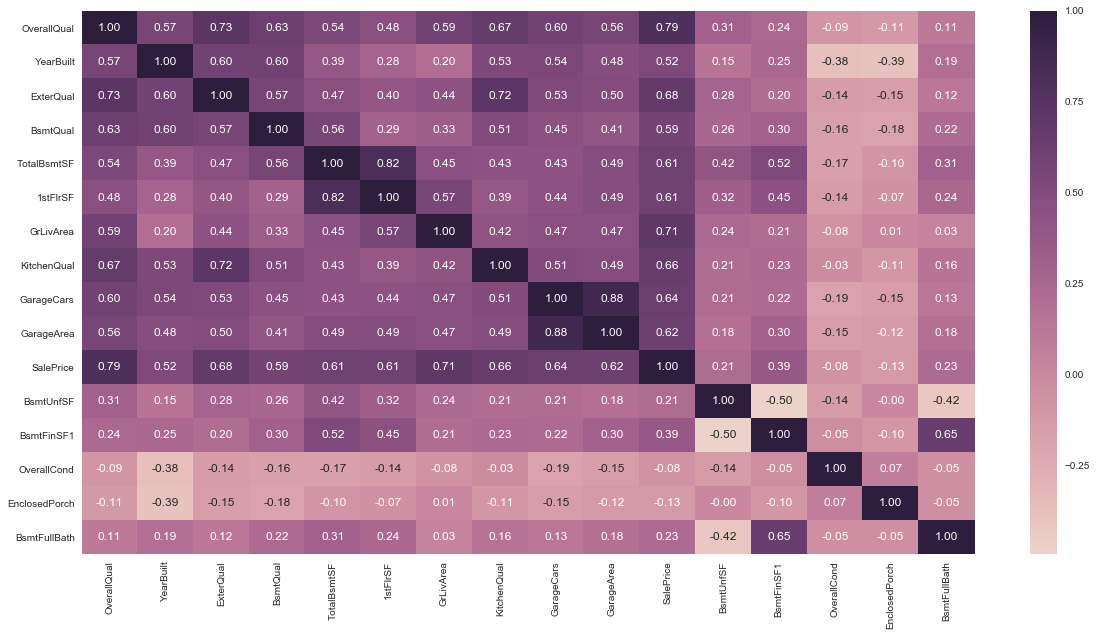

In [340]:
# Reference for Heatmap: https://seaborn.pydata.org/generated/seaborn.heatmap.html
_, ax = plt.subplots(figsize=(20,10))  
sb.heatmap(ftr_corr_matrix, annot=True, fmt=".2f", cmap=sb.cubehelix_palette(300), ax=ax)

### Result for Part 1
So, the features selected in above section are: ['OverallQual', 'YearBuilt', 'ExterQual', 'BsmtQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'KitchenQual', 'GarageCars', 'GarageArea','BsmtUnfSF', 
 'BsmtFinSF1', 'OverallCond', 'EnclosedPorch', 'BsmtFullBath']
 
 All of these features are highly correlated with SalePrice.


The above shown heatmap depicts the correlation among the interesting features that I chose after some analysis.
As it is noticable the most positive correlations are:

- OverallQual and SalePrice, this is quite explanatory as the house with higher overall quality will generally have a higer price. (Correlation = 0.79)
- GrLivArea and SalePrice, this also confirms the fact that houses larger in area will generally be pricier. (Correlation = 0.71)
- ExterQual and KitchenQual also have a high correlation of 0.72 

Apart from this the feature pairs with most negative correlations are:

- BsmtFinSF1 and BsmtUnfSF have the most negative correlation of -0.5, this is justifiable as Unfinished square feet of basement area is usually negatively correlated with Finished Area.
- OverallCond and YearBuilt also have a negative correlation of -0.38.

#### References:
1. Heatmap Visualization: https://seaborn.pydata.org/generated/seaborn.heatmap.html
2. Reference Count NULL values: https://stackoverflow.com/a/26266451/5512174

## Part 2 - Informative Plots

### Plot 1

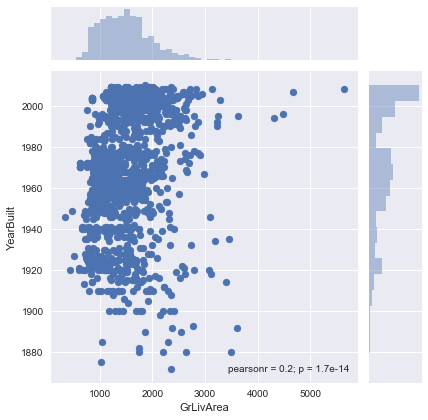

In [341]:
#Reference for jointplot: https://seaborn.pydata.org/generated/seaborn.jointplot.html
sb.jointplot(x="GrLivArea", y="YearBuilt", data=ftr_corr_df)

The plot preseted above is a Scatterplot and histogram of GrLivArea and YearBuilt features. Following observations can be deduced from the visualtion:

- The scatter plot shows positive correlation between GrLivArea and YearBuilt. This means that over the time the area of houses has increased.

- The histogram plot for the GrLivArea depicts that a few houses have very high GrLivArea as compared to mean. 

### Plot 2

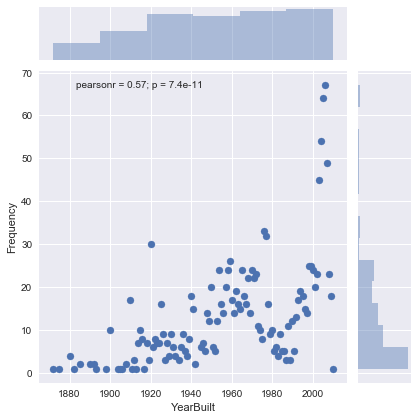

In [342]:
year_plot = train_df[['YearBuilt']]
#Reference for reset_index: https://stackoverflow.com/a/38224955/5512174
year_plot = year_plot.groupby(['YearBuilt']).size().reset_index(name='Frequency')
year_plot = year_plot.sort_values(by=['YearBuilt'])

#Reference for jointplot: https://seaborn.pydata.org/generated/seaborn.jointplot.html
sb.jointplot(x="YearBuilt", y="Frequency", data=year_plot)

year_plot = year_plot.loc[year_plot['YearBuilt'] > 1990]


The line-chart above is between YearBuilt(X-axes) and Frequency (Number of Houses Built) for each year (Y-axes).
Following insights are obtained from this visualization.

- There is a strong positive correlation in the Frequency of houses built each year, which suggests that more houses were being built as the years progressed.

- Also, if you notice the line plot below (after year 1990), which has Year Built as X-axes and Frequency (Number of Houses Built) as Y-axes, the overall trend is increasing however, from year mid 2006 onwards the frequency of houses has decreased starkly. This might be due to the economic slowdown and housing market crisis that hit the US markets during 2007-2008

#### References:
- Reference for reset_index in pandas groupby: https://stackoverflow.com/a/38224955/5512174
- Reference for jointplot visualization: https://seaborn.pydata.org/generated/seaborn.jointplot.html
- Reference for generating a line plot: https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.plot.line.html

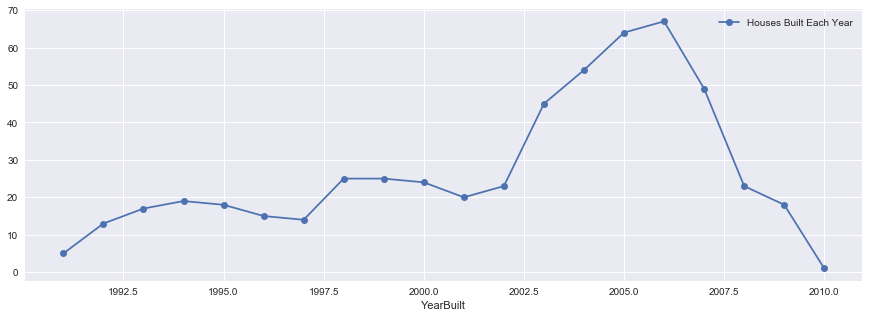

In [343]:
#Reference for generating a line plot: 
#https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.plot.line.html
_, ax = plt.subplots(figsize=(15,5))
year_plot.plot.line(x='YearBuilt', y='Frequency', marker='o', ax=ax, label="Houses Built Each Year")

### Plot 3

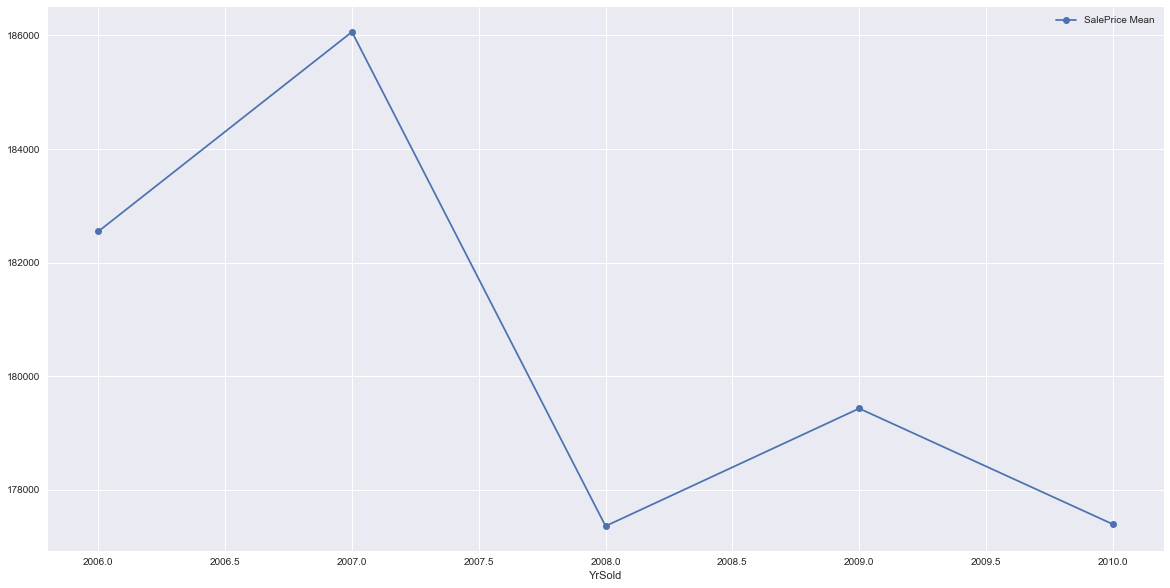

In [344]:
#Reference for reset_index: https://stackoverflow.com/a/38224955/5512174
year_plot = train_df[['YrSold', 'SalePrice']]
year_plot = year_plot.groupby(['YrSold'])['SalePrice'].mean().reset_index(name='SalePrice Mean')
year_plot = year_plot.sort_values(by=['YrSold'])

#Reference for generating a line plot: 
#https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.plot.line.html

_, ax = plt.subplots(figsize=(20,10))  
year_plot.plot.line(x='YrSold', y='SalePrice Mean',marker='o', ax=ax)

This plot depicts SalePrice Mean for each Year the house was sold. Some interesting observations are:

- Although the SalePrice Mean was increaing from 2006 to 2007 there is a very steep SalePrice decline from Year 2007 to 2008.

- One of the reasons for this decline is the Economy Slowdown that hit the Stock Market and Real Estate in the US from 2007-2008. During this period the SalePrice of houses declined exponentially as depicted in the graph.

#### References:

- Reference for reset_index in pandas groupby: https://stackoverflow.com/a/38224955/5512174
- Reference for generating a line plot: https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.plot.line.html

### Plot 4

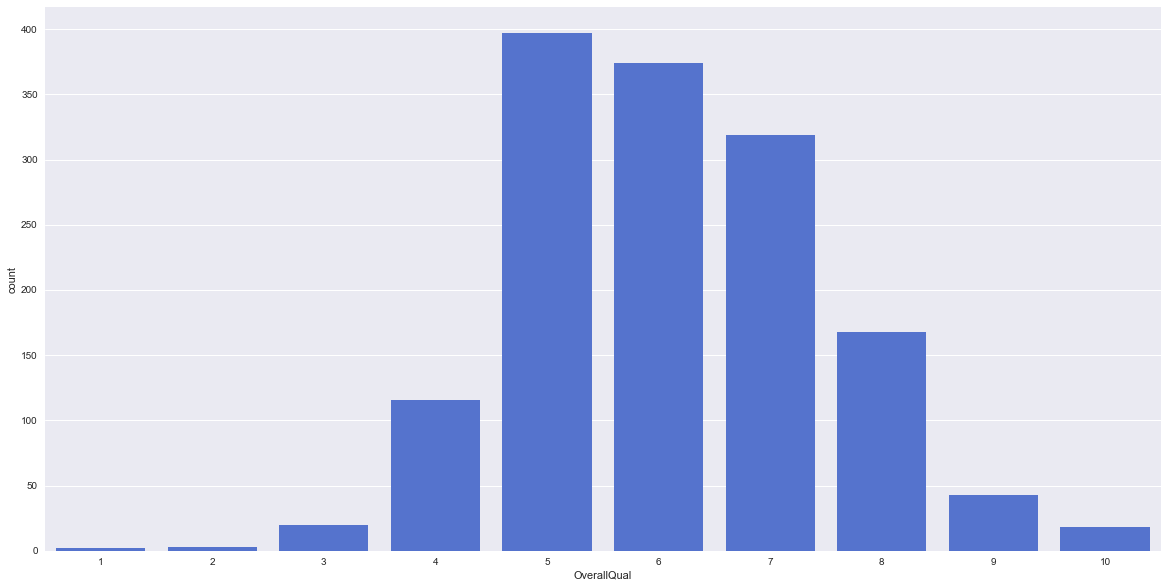

In [345]:
#Reference countplot: https://seaborn.pydata.org/generated/seaborn.countplot.html
_, ax = plt.subplots(figsize=(20,10))  
sb.countplot(x="OverallQual", data=train_df, ax=ax, palette=['royalblue'])


This is a countplot of number of houses of each quality type. From this it is clear that:
- Most of the houses in the dataset have average quality ranging from 5-7 with houses of quality 5 being maximum.
- There are very few houses of low (1-2) or high (9-10) quality.

#### References:
- Reference countplot: https://seaborn.pydata.org/generated/seaborn.countplot.html


### Plot 5

In [346]:
#Reference for reset_index: https://stackoverflow.com/a/38224955/5512174
display(train_df.groupby('OverallQual').size().reset_index(name="count"))

,OverallQual,count
0,1,2
1,2,3
2,3,20
3,4,116
4,5,397
5,6,374
6,7,319
7,8,168
8,9,43
9,10,18


For the fourth plot I wanted to study the relationship between type of dwelling (MSSubClass) and OverallQuality of Housing available. For this I have divided OverallQual into 2 categories:

- Top Quality consisting of OverallQual in range [8,10]
- Low Quality consisting of OverallQual in range [1,4]

In [347]:
qual_df = train_df[['OverallQual', 'MSSubClass']]
top_qual = qual_df[qual_df['OverallQual'].isin([8,9,10])]
low_qual = qual_df[qual_df['OverallQual'].isin([1,2,3,4])]

In [348]:
#Reference for reset_index: https://stackoverflow.com/a/38224955/5512174
display(top_qual.groupby('MSSubClass').size().reset_index(name="count"))

,MSSubClass,count
0,20,94
1,50,5
2,60,86
3,70,6
4,75,3
5,80,2
6,120,31
7,160,2


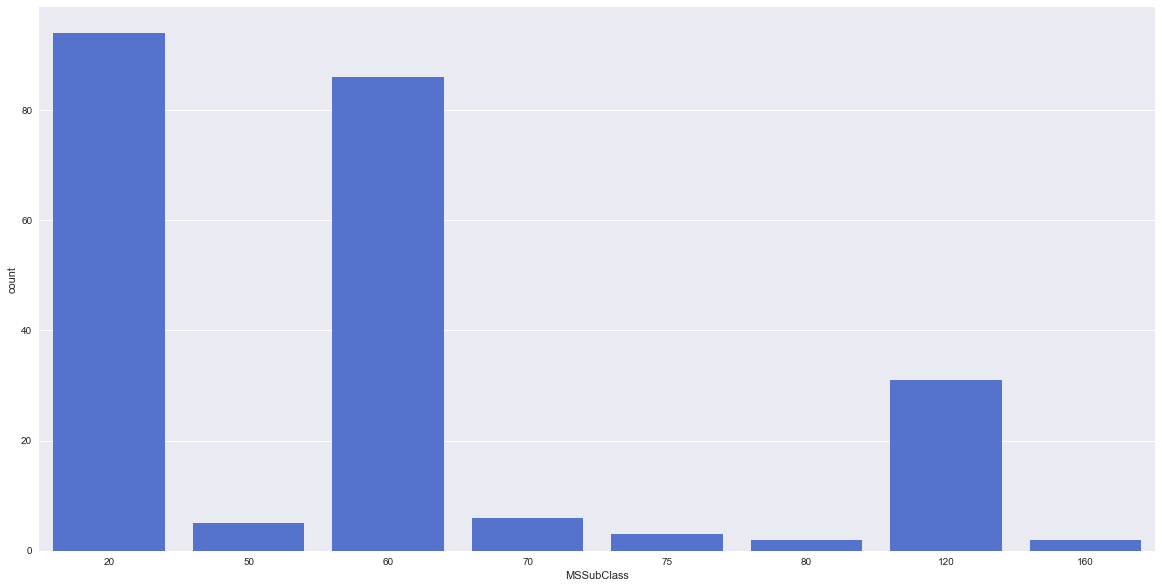

In [349]:
#Reference countplot: https://seaborn.pydata.org/generated/seaborn.countplot.html
_, ax = plt.subplots(figsize=(20,10))  
sb.countplot(x="MSSubClass", data=top_qual, ax=ax, palette=['royalblue'])


This plot shows the frequency of each type of dwelling in the top quality. It can be observed that MSSubClass 20 (1-STORY 1946 & NEWER ALL STYLES) has hihgest top quality houses this is infact because most of the houses present in the dataset are from this category.

This is followed by MSSubClass 60 (2-STORY 1946 & NEWER) having second highest number of top quality houses.

In [350]:
#Reference for reset_index: https://stackoverflow.com/a/38224955/5512174
display(low_qual.groupby('MSSubClass').size().reset_index(name="count"))

,MSSubClass,count
0,20,49
1,30,30
2,45,1
3,50,24
4,70,5
5,75,1
6,80,1
7,85,1
8,90,11
9,160,4


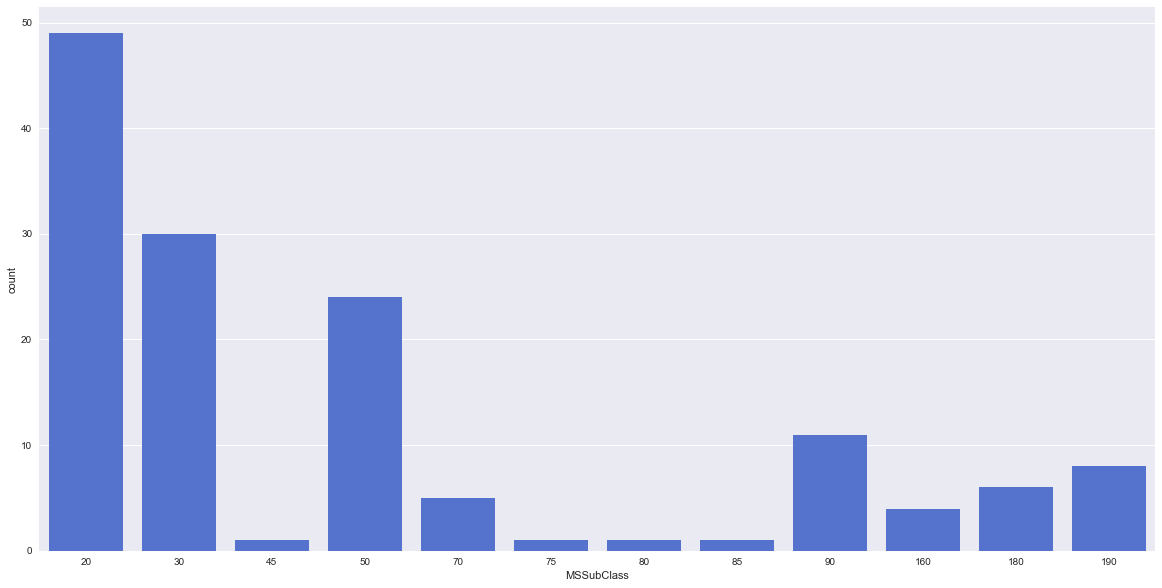

In [351]:
#Reference countplot: https://seaborn.pydata.org/generated/seaborn.countplot.html
_, ax = plt.subplots(figsize=(20,10))  
sb.countplot(x="MSSubClass", data=low_qual, ax=ax, palette=['royalblue'])


This plot shows the frequency of each type of dwelling in the low quality. It can be observed that MSSubClass 20 (1-STORY 1946 & NEWER ALL STYLES) has hihgest low quality houses this is infact because most of the houses present in the dataset are from this category.

This is followed by MSSubClass 30 (1-STORY 1945 & OLDER) having second highest number of low quality houses.

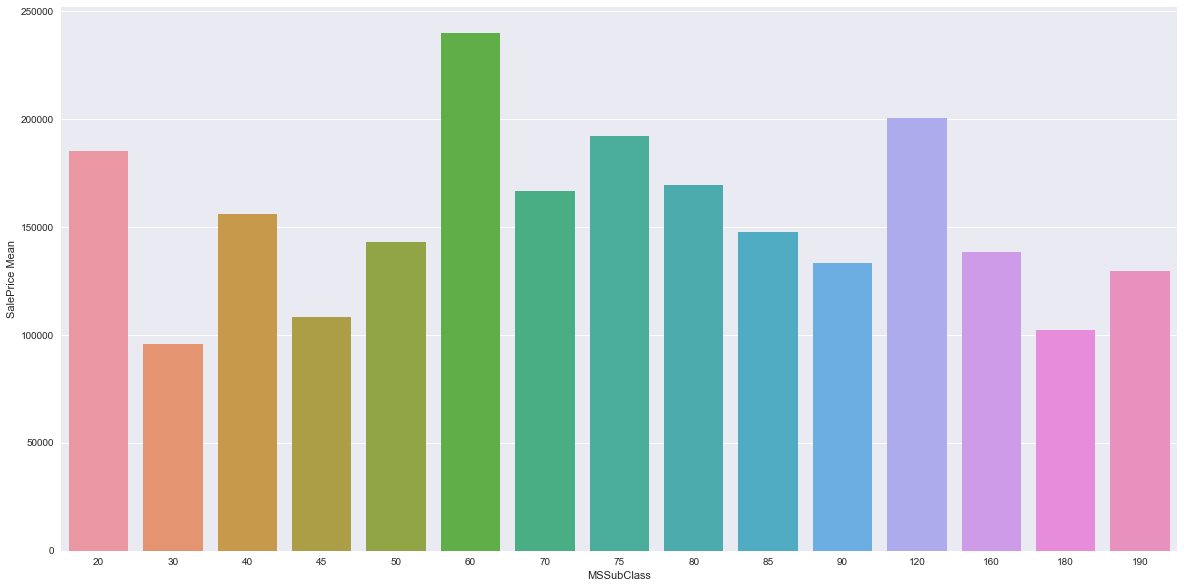

In [352]:
#Reference for reset_index: https://stackoverflow.com/a/38224955/5512174
mssub_plot = train_df[['MSSubClass', 'SalePrice']]
mssub_plot = mssub_plot.groupby(['MSSubClass'])['SalePrice'].mean().reset_index(name='SalePrice Mean')

#Reference for barplot: https://seaborn.pydata.org/generated/seaborn.barplot.html
_, ax = plt.subplots(figsize=(20,10))  
sb.barplot(x='MSSubClass', y='SalePrice Mean', data=mssub_plot, ax=ax)


This bar-plot of MSSubClass (X-axes) vs SalesPrice Mean in each class (Y-axes) also confirms the earlier observations. 
- As it can be observed that MSSubClass 60 has the hihgest SalePrice as it has second hihgest number of top quality houses and very less low qualitty houses.
- Furthermore, MSSubClass has the lowest SalePrice mean as it had second maximum low quality housing and very less top quality houses.
- Lastly MSSubClass 20 has average high SalePrice mean as it had maximum low quality as well as maximum high quality housing.

#### References:

- Reference for reset_index in pandas groupby: https://stackoverflow.com/a/38224955/5512174
- Reference for barplot: https://seaborn.pydata.org/generated/seaborn.barplot.html
- Reference countplot: https://seaborn.pydata.org/generated/seaborn.countplot.html


## Part 3 - Handcrafted Scoring Function

To devise a handcrafted scoring metric to measure 'desirability' of a given house I first concluded that:

1. SalePrice may not exactly define 'desirability' of a given house but it gives a very good idea if a house is desierable or not. Usually houses with good features and qualities are coveted and are desirable.

2. So for this purpose I chose to factor in features like overall Quality, Area, Finish etc. as these features give a good idea abnout the condition of a given house, are highly correlated with SalePrice and can be taken as a parameter to the scoring function.

3. The SalePrice however, in itself cannot be taken as a parameter as it is an estimated quantifiable value of house, but it is also affected by external factors like population, economy and availability etc.

So in the following section I have taken features that I think can be a useful parameter in determining the desirability of a given house and each features Pearson value with SalePrice is it's weight in the calculation.

In [353]:
#Calculating weights for each of the feature selected
corr_dict = {}
score_ftr = ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'ExterQual',
             'BsmtQual', '1stFlrSF', 'GrLivArea', 'FullBath',
             'KitchenQual', 'GarageFinish', 'GarageArea']

for ftr in score_ftr:
    corr_dict[ftr] = abs(ftr_df[ftr].corr(ftr_df['SalePrice']))

print(corr_dict)
    

{'OverallQual': 0.7909816005838047, 'YearBuilt': 0.5228973328794969, 'YearRemodAdd': 0.5071009671113865, 'ExterQual': 0.6368836943991134, 'BsmtQual': 0.6208861300191691, '1stFlrSF': 0.6058521846919148, 'GrLivArea': 0.7086244776126522, 'FullBath': 0.5606637627484456, 'KitchenQual': 0.5891887782994202, 'GarageFinish': 0.5492467563332121, 'GarageArea': 0.6234314389183617}


In [354]:
qual_dict = {
              'Ex' : 5,
              'Gd' : 4,
              'TA' : 3,
              'Fa' : 2,
              'Po' : 1,
              'NA' : 0,
              'Fin' : 3,
              'RFn' : 2,
              'Unf' : 1,
              'NA'  : 0
           }

In [355]:
#Utility function to encode required categorical features/
def process_data(df, house_id):
    record = df.loc[df['Id'] == house_id]
    val_dict = {}

    for ftr in score_ftr:
        val_dict[ftr] = record[ftr][(house_id - 1)%1460]
    
    for cat_ftr in ['ExterQual', 'BsmtQual', 'KitchenQual', 'GarageFinish']:
        if val_dict[cat_ftr] in qual_dict:
            val_dict[cat_ftr] = qual_dict[val_dict[cat_ftr]]
        else:
            val_dict[cat_ftr] = 0
    
    return val_dict

In [356]:
#Function to calculate "desirability score" as aweighted sum of important features
def cal_desirability_score(df, house_id):
    val_dict = process_data(df, house_id)
    weight_sum = 0

    for ftr in val_dict:
        weight_sum += (corr_dict[ftr]*val_dict[ftr])
    
    return weight_sum
    
    

The function above defines the desirability score as a weighted sum of the chosen parameters. So, now in the following section I have calculated the desirability score of each house in the dataset and stored the value as 'desire_sc' feature. Also the correlatio between desirability and SalePrice is strongly positive.

In [357]:
train_df['desire_sc'] = train_df['Id'].transform(lambda x: cal_desirability_score(train_df, x))

In [358]:
print(train_df['desire_sc'].corr(train_df['SalePrice']))

0.796948354769249


In [359]:
main_ftr_list = ['Id', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'ExterQual', 'BsmtQual', 
                 'TotalBsmtSF','1stFlrSF', 'GrLivArea', 'FullBath', 'KitchenQual', 
                 'TotRmsAbvGrd', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageArea',
                 'SalePrice',  'desire_sc']

### 10 Most Desirable Houses

In [360]:
#Listing top 10 houses with maximum desirability score
display(train_df[main_ftr_list].nlargest(10, 'desire_sc'))

,Id,OverallQual,YearBuilt,YearRemodAdd,ExterQual,BsmtQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,GarageType,GarageFinish,GarageCars,GarageArea,SalePrice,desire_sc
1298,1299,10,2008,2008,Ex,Ex,6110,4692,5642,2,Ex,12,Attchd,Fin,2,1418,160000,9812.893797
523,524,10,2007,2008,Ex,Ex,3138,3138,4676,3,Ex,11,BuiltIn,Fin,3,884,184750,7853.993635
1182,1183,10,1996,1996,Gd,Ex,2396,2411,4476,3,Ex,10,Attchd,Fin,3,813,745000,7215.076603
691,692,10,1994,1995,Ex,Ex,2444,2444,4316,3,Ex,10,Attchd,Fin,3,832,755000,7132.618994
496,497,8,1992,1993,Gd,Gd,3200,3228,3228,3,Gd,10,Attchd,RFn,2,546,430000,6652.284118
1268,1269,8,1935,1997,TA,TA,728,1968,3447,3,Gd,11,BuiltIn,Unf,3,1014,381000,6306.281279
1024,1025,8,1976,1976,Gd,Gd,1565,2898,2898,2,Gd,10,Attchd,Fin,2,665,287000,6275.696670
1169,1170,10,1995,1996,Gd,Ex,1930,1831,3627,3,Gd,10,Attchd,Fin,3,807,625000,6257.207479
304,305,7,1880,2002,TA,TA,1470,1675,3493,3,Gd,10,Attchd,Unf,3,870,295000,6044.574357
1373,1374,10,2001,2002,Ex,Ex,2633,2633,2633,2,Ex,8,Attchd,RFn,3,804,466500,6043.154058


- Houses listed above are the 10 most desirable houses in the given dataset. According to my analysis this is a good result as most of these houses have maximum OverallQual, ExterQual, BsmtQual, very large area, good number of rooms and garage as well. 

- One interesting thing to note is that the houses with hihgest desirability score may not have highest of SalePrices. However, these variables are related as the priciest house in the dataset (ID 692) with SalePrice 755000 is in top 5.

### 10 Least Desirable Houses

In [361]:
#Listing 10 houses with minimum desirability score
display(train_df[main_ftr_list].nsmallest(10, 'desire_sc'))

,Id,OverallQual,YearBuilt,YearRemodAdd,ExterQual,BsmtQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,GarageType,GarageFinish,GarageCars,GarageArea,SalePrice,desire_sc
533,534,1,1946,1950,Fa,NaN,0,334,334,1,Fa,2,NaN,NaN,0,0,39300,2449.244091
1100,1101,2,1920,1950,TA,TA,290,438,438,1,Fa,3,Detchd,Unf,1,246,60000,2729.558238
528,529,4,1920,2002,TA,TA,528,605,605,1,TA,5,NaN,NaN,0,0,86000,2823.702862
916,917,2,1949,1950,TA,TA,480,480,480,0,TA,4,Detchd,Unf,1,308,35311,2838.611555
29,30,4,1927,1950,TA,TA,520,520,520,1,Fa,4,Detchd,Unf,1,240,68500,2838.846980
649,650,4,1970,1970,TA,Gd,630,630,630,1,TA,3,NaN,NaN,0,0,84500,2867.103300
1449,1450,5,1970,1970,TA,Gd,630,630,630,1,Ex,3,NaN,NaN,0,0,92000,2869.072659
434,435,4,1972,1972,TA,Gd,630,630,630,1,TA,3,NaN,NaN,0,0,81000,2869.163297
614,615,4,1972,1972,TA,Gd,630,630,630,1,TA,3,NaN,NaN,0,0,75500,2869.163297
125,126,6,1935,1982,TA,TA,520,520,754,1,TA,5,NaN,NaN,0,0,84500,2877.073877


- Houses listed above are the 10 least desirable houses in the given dataset. According to my analysis this is a good result as most of these houses have minimum OverallQual, ExterQual, BsmtQual, very less area, less number of rooms and unfinished or no garage at all. 


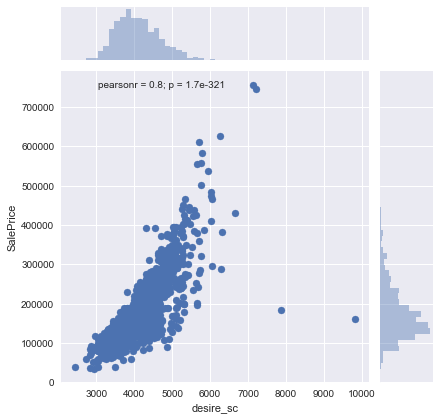

In [362]:
#Reference for jointplot: https://seaborn.pydata.org/generated/seaborn.jointplot.html
sb.jointplot(x="desire_sc", y="SalePrice", data=train_df)

As the scatter plot above depicts the "desire_sc" (desirability score according my scoring funciton) is highly correlated with SalePrice as I had stated earlier that Expensive houses are generally more desirable due the quality, finish and size they have.

#### References:
- Reference for jointplot: https://seaborn.pydata.org/generated/seaborn.jointplot.html

## Part 4 - Pairwise Distance Function

For this task I have devised a pairwise distance function that takes into account certain important features like OverallQual, GrLivArea, TotRmsAbvGrd etc. which are fundamental in differentiating between two houses.

In [363]:
#Selecting important features for pairwise distance function
dist_ftrs = ['Id', 'OverallQual', 'ExterQual', 'BsmtQual', 'FullBath', 'KitchenQual', 'GarageFinish', 
             'FullBath', 'KitchenAbvGr',  'PoolQC', 'Fence', 'MSZoning', 'TotRmsAbvGrd',
             '1stFlrSF', 'GrLivArea',  'GarageArea', 'LotArea', 'BsmtFinSF1']

dist_df = ftr_df[dist_ftrs]

Following housing_dist function takes as argument two Numpy arrays (2 vectors describing the 2 houses) and calculates the paiwise distance betweemn the houses as a net summation of  weighted distance between the selected features shown in the list above.

The weights are chosen based on importance of features.

In [364]:
#Pairwise distance function
def housing_dist(rec1, rec2):
    final_dist, dist1, dist2 = 0, 0, 0
    
    wt_list = [0.8, 0.15, 0.16, 0.1, 0.12, 0.1, 0.1, 0.12, 0.1, 0.1, 0.25, 0.5]
    
    for i in range(1, 12):
        dist1 += abs(rec1[i] - rec2[i])*wt_list[i]*1000

    for i in range(13, 18):
        dist2 += rec1[1]**2 - rec2[1]**2

    final_dist = dist1 + np.sqrt(dist2)
    return final_dist


The pairwise distance function implemented above takes in critical features of the property like OverallQual, KitchenQual, GrLivArea, etc. and calculates weighted distance among these features to find the "pairwise distance" between the properties.

In [365]:
# Selecting 4 houses (2 top quality and 2 low quality)
top_house1 = dist_df.values[523]
top_house2 = dist_df.values[1182]

low_house1 = dist_df.values[1100]
low_house2 = dist_df.values[916]

In [366]:
#Distance between 2 top quality houses
print(housing_dist(top_house1, top_house2))

1120.0


In [367]:
#Distance between top quality and low house
print(housing_dist(top_house2, low_house1))

3261.9089023002066


In [368]:
#Distance between top quality and low house
print(housing_dist(top_house2, low_house2))

5201.908902300207


In [369]:
#Distance between 2 low quality houses
print(housing_dist(low_house1, low_house2))

1940.0


### Result for Part 4
For the purpose of verification of the pairwise distance function devised I took 4 houses from the dataset and labelled them as:
- top_house1 and top_house2 : Top quality houses chosen from the dataset with large area, lots of rooms etc.
- low_house1 and low_house2 : Low quality houses chosen from the dataset with less area, less rooms, less bathrooms etc.

It can be noted from the calculation presented above that the distance between a pair top quality houses (1120) and between a pair of low quality houses (1940) is less as compared to distance between a pair containing a top quality house and a low quality house.

This preliminary test does validate the pairwise distance function to a certain extent.


## Part 5 - Clustering

In [370]:
#Reference standard scaler: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
scale_dist = StandardScaler().fit_transform(dist_df)

For generating the clustering visualization using the custom distance metric developed in Part 4, I have leveraged T-SNE Manifold clustering visualization (as suggested by Professor Skiena on Piazza).

This algorithm is useful in visualizing a multi dimensional data in a 2D space and generating clustering visualization.

In [371]:
#Reference for T-SNE visulaization: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
neigh_plot = TSNE(n_components = 2, perplexity = 20, learning_rate=100, metric = housing_dist).fit_transform(scale_dist)

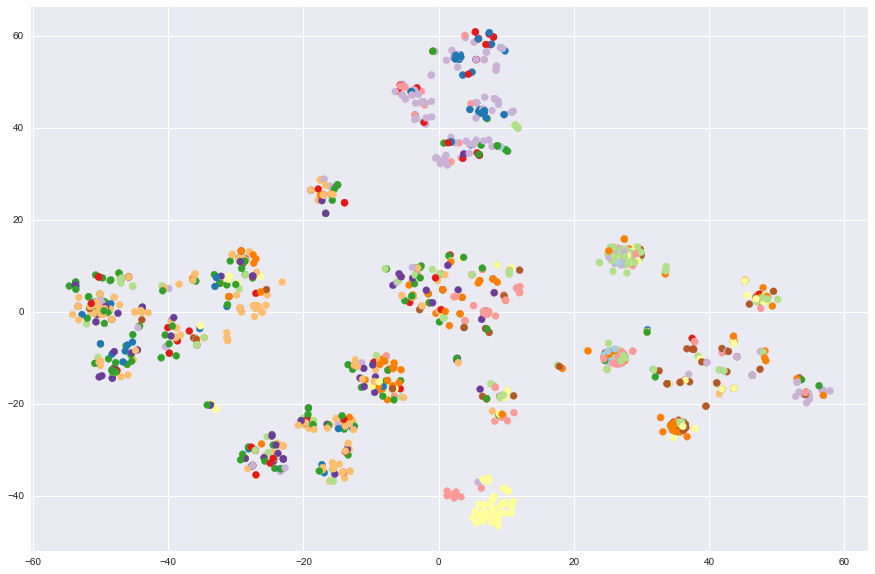

In [372]:
#Reference scatterplot: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.scatter.html
_, ax = plt.subplots(figsize=(15,10))  
ax.scatter(neigh_plot[:,0], neigh_plot[:,1], c = ftr_df['Neighborhood'], cmap='Paired')

### Result for Part 5
Each point is a house in the visualization above and the different colors represent different neighborhoods. So some of the insights that can be drawn from the above presented visualization are:

- Apart from a few neighborhoods each neighborhood contains mixed types of houses in the given dataset.
- Some of the neighborhoods do have houses of a single type in majority as shown in the visualization.
- The houses given in the dataset can be easily clustered into 10 clusters each with varying characterisitics.

#### Reference:
- Reference scatterplot: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.scatter.html
- Reference for T-SNE visulaization: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
- Reference standard scaler: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

## Part 6 - Linear Regression

In [373]:
#Reference: Reused from my HW2 submission (cse519_hw2_Negi_HardikSingh_111886786.ipynb)
#Class with factory method to generate all the ML models needed in this assignment using
# the scikit-learn library, LGBM library and XG Boost Library.

#ML model funcitons reference:
#1. Reference for XGBoost: https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
#2. Reference for LGBM: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor
#3. Reference ADA Boost: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html
#4. Reference Random Forest: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
#5. Reference for KNN: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

class Model_Helper:
    def __init__(self, type_m):
        self.reg_model = None
        if type_m == "neigh":
            self.reg_model = KNeighborsRegressor()
        elif type_m == "random_f":
            self.reg_model = RandomForestRegressor()
        elif type_m == "ada":
            self.reg_model = AdaBoostRegressor()
        elif type_m == "xgb":
            self.reg_model = XGBRegressor()
        elif type_m == "lgb":
            self.reg_model = LGBMRegressor()
        elif type_m == "lin_reg":
            self.reg_model = LinearRegression()
        else:
            print("Enter valid choice")

    def train_model(self, train_data, train_lbl):
        self.reg_model.fit(train_data, train_lbl)

    def gen_preds(self, test_data):
        return self.reg_model.predict(test_data)

For this task I have chosen the features that I found in Part 1 to have a very high correlation with SalePrice as that is the entity that I have to predict. So the features of a house that are highly correlated with SalePrice will give a decent idea about it's value

In [374]:
#Selecting features for linear regression
mdl_df = ftr_df[['OverallQual', 'YearBuilt', 'YearRemodAdd', 'ExterQual', 'BsmtQual',
       'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'KitchenQual',
       'TotRmsAbvGrd', 'GarageType', 'GarageFinish', 'GarageCars',
       'GarageArea']]
res = ftr_df[['SalePrice']]

In [375]:
pretty_display_df(res, "Testing Set", 10)

Testing Set Dataframe Shape:(1460, 1)


,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000
5,143000
6,307000
7,200000
8,129900
9,118000


In [376]:
#Scikit learn train_test_split function
train_data, dev_data, train_lbl, dev_lbl = train_test_split(mdl_df, res, test_size=0.25, random_state=5)

In [377]:
#Reference Linear Regression:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
lin_reg = Model_Helper('lin_reg')
lin_reg.reg_model.set_params(normalize=True)
lin_reg.train_model(train_data, train_lbl)

In [378]:
pred_gen = lin_reg.gen_preds(dev_data)

In [379]:
#Calculating Log RMSE
m_err = mean_squared_error(np.log(dev_lbl), np.log(pred_gen))
r_err = np.sqrt(m_err)
print(r_err)

0.23135833210198478


In [380]:
#Getting the coefficient for each of the feature
coff = lin_reg.reg_model.coef_.tolist()[0]

In [381]:
lin_dict = {}
for idx, ftr in enumerate(mdl_df.columns):
    lin_dict[ftr] = abs(coff[idx])

In [382]:
#Listing the absolute coefficient value for each feature
sorted_x = sorted(lin_dict.items(), key=lambda kv: -kv[1])
for tup in sorted_x:
    print("Feature: "+tup[0]+"    Coeff Score: "+str(tup[1]))

Feature: OverallQual    Coeff Score: 15263.040765456994
Feature: BsmtQual    Coeff Score: 11324.963363775669
Feature: KitchenQual    Coeff Score: 11255.661974526112
Feature: GarageCars    Coeff Score: 10293.133643186631
Feature: ExterQual    Coeff Score: 7173.231047402926
Feature: FullBath    Coeff Score: 3509.8187244580827
Feature: TotRmsAbvGrd    Coeff Score: 2740.2538621409244
Feature: GarageFinish    Coeff Score: 2030.844842674519
Feature: GarageType    Coeff Score: 413.84313756991685
Feature: YearBuilt    Coeff Score: 153.36047944204438
Feature: YearRemodAdd    Coeff Score: 83.81189241935299
Feature: GrLivArea    Coeff Score: 32.975029052109576
Feature: 1stFlrSF    Coeff Score: 19.815945746433954
Feature: GarageArea    Coeff Score: 10.769107244385092
Feature: TotalBsmtSF    Coeff Score: 6.770554946788336


### Result for Part 6

- The overall performance of the Linear regression model is not good as compared to other complex models described in the following sections.
- This can be observed from a log RMSE of 0.23 of the housing prices predicted.
- This is understandable as the linear regression model is a simple prediction model which tries explains the data points via line plot and this might not be suitable in all scenarios.
- As for the importance it can be noted from the coeff value that OverallQual, BsmtQual, KitchenQual and GarageCars are the most important features in this model.
- The least important features in this model are TotalBsmtSF, GarageArea and 1stFlrSF.

#### References:
1. Reference Linear Regression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
2. Reference for XGBoost: https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
3. Reference for LGBM: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor
4. Reference ADA Boost: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html
5. Reference Random Forest: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
6. Reference for KNN: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html


## Part 7 - External Dataset

In this part I have leveraged two external datasets to generate insights into the Housing dataset.

In [383]:
unemp_df = df_hdl.read_from_csv('/Users/hardik/Desktop/CSE-519/HW3/house-prices-advanced-regression-techniques/unemp.csv')

Reading Data from: /Users/hardik/Desktop/CSE-519/HW3/house-prices-advanced-regression-techniques/unemp.csv


The first dataset is the unemployment dataset of Ames, Iowa (link: https://fred.stlouisfed.org/series/AMES119URN)
I have tried to correlate number houses built each year along with Unemployment Rate for that particular year.

In [384]:
#Renaming the column of the dataset
unemp_df = unemp_df.rename(columns={"AMES119URN": "Unemp_Rate"})
pretty_display_df(unemp_df, "Unemployment", 10)

Unemployment Dataframe Shape:(356, 2)


,DATE,Unemp_Rate
0,1990-01-01,3.9
1,1990-02-01,3.5
2,1990-03-01,3.3
3,1990-04-01,3.0
4,1990-05-01,3.4
5,1990-06-01,3.9
6,1990-07-01,3.7
7,1990-08-01,4.0
8,1990-09-01,4.3
9,1990-10-01,4.1


In [385]:
#Reference for reset_index: https://stackoverflow.com/a/38224955/5512174
unemp_df['YearBuilt'] = unemp_df['DATE'].transform(lambda x: x[:4]).astype(int)
unemp_df = unemp_df.groupby(['YearBuilt'])['Unemp_Rate'].mean().reset_index(name="unemp_idx_mean")


In [386]:
#Reference for reset_index: https://stackoverflow.com/a/38224955/5512174
year_plot = train_df.groupby(['YearBuilt']).size().reset_index(name='HousesBuilt')
pretty_display_df(year_plot, "Frequency of Houses per year", 15)

Frequency of Houses per year Dataframe Shape:(112, 2)


,YearBuilt,HousesBuilt
0,1872,1
1,1875,1
2,1880,4
3,1882,1
4,1885,2
5,1890,2
6,1892,2
7,1893,1
8,1898,1
9,1900,10


In [387]:
explore_df = df_hdl.merge_dataframe(year_plot, unemp_df, "YearBuilt", "left")
explore_df = explore_df.dropna()
display(explore_df)

Merging the Dataframes
Dataframes Merged


,YearBuilt,HousesBuilt,unemp_idx_mean
91,1990,12,3.758333
92,1991,5,3.916667
93,1992,13,3.608333
94,1993,17,3.066667
95,1994,19,2.816667
96,1995,18,2.775000
97,1996,15,2.683333
98,1997,14,2.566667
99,1998,25,2.508333
100,1999,25,2.150000


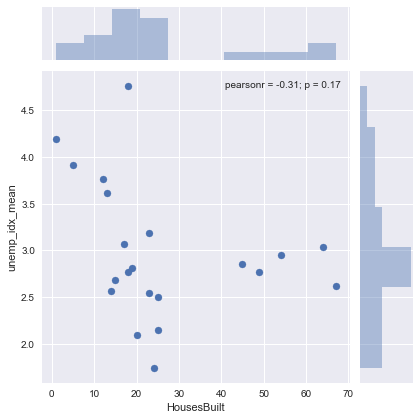

In [388]:
#Reference for jointplot: https://seaborn.pydata.org/generated/seaborn.jointplot.html
sb.jointplot(x= 'HousesBuilt', y= 'unemp_idx_mean', data=explore_df)

As observed from the jointplot above there is a negative correlation (-0.31) between the number of houses built each year and the mean unemployment rate for each year.

This  is indicating the fact that if in any year the unemployment rate is comparatively higher then the number houses built in that particular year are generally less as compared to other years.

In [389]:
gdp_df = df_hdl.read_from_csv('/Users/hardik/Desktop/CSE-519/HW3/house-prices-advanced-regression-techniques/ames_gdp.csv')

Reading Data from: /Users/hardik/Desktop/CSE-519/HW3/house-prices-advanced-regression-techniques/ames_gdp.csv


The next dataset that I chosen is the Ames, Iowa GDP dataset (link: https://fred.stlouisfed.org/series/RGMP11180)

Using this dataset I have explore the relation between the SalePrice each year and the GDP of the city in that particular year.

In [390]:
gdp_df = gdp_df.rename(columns={"RGMP11180": "GDP"})
gdp_df['YearBuilt'] = gdp_df['DATE'].transform(lambda x: x[:4]).astype(int)
pretty_display_df(gdp_df, "GDP", 10)

GDP Dataframe Shape:(17, 3)


,DATE,GDP,YearBuilt
0,2001-01-01,3193,2001
1,2002-01-01,3180,2002
2,2003-01-01,3237,2003
3,2004-01-01,3350,2004
4,2005-01-01,3400,2005
5,2006-01-01,3583,2006
6,2007-01-01,3683,2007
7,2008-01-01,4038,2008
8,2009-01-01,3700,2009
9,2010-01-01,3707,2010


In [391]:
#Reference for reset_index: https://stackoverflow.com/a/38224955/5512174
year_plot = train_df.groupby(['YearBuilt'])['SalePrice'].mean().reset_index(name='SalePriceMean')
pretty_display_df(year_plot, "SalePriceMean", 10)

SalePriceMean Dataframe Shape:(112, 2)


,YearBuilt,SalePriceMean
0,1872,122000.00
1,1875,94000.00
2,1880,200619.75
3,1882,168000.00
4,1885,111250.00
5,1890,142200.00
6,1892,291250.00
7,1893,325000.00
8,1898,106000.00
9,1900,112492.60


In [392]:
explore_df = df_hdl.merge_dataframe(year_plot, gdp_df, "YearBuilt", "left")
explore_df = explore_df.dropna()

Merging the Dataframes
Dataframes Merged


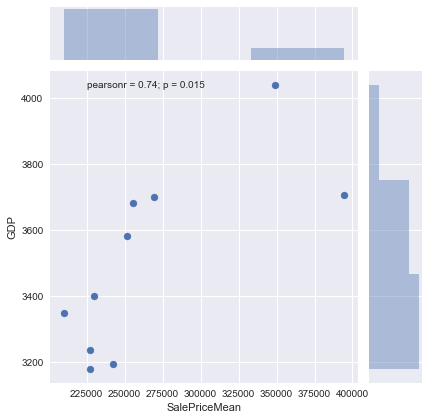

In [393]:
#Reference for jointplot: https://seaborn.pydata.org/generated/seaborn.jointplot.html
sb.jointplot(x="SalePriceMean", y="GDP", data=explore_df)

As you can observe from the jointplot above, SalePrice and GDP are hihghly positively correlated. This means that if GDP for a year was high then the SalePrice for that year was also high.
 
#### References:
1. Reference for reset_index with pandas groupby: https://stackoverflow.com/a/38224955/5512174
2. Reference for jointplot: https://seaborn.pydata.org/generated/seaborn.jointplot.html


## Part 8 - Permutation Test

For the permutation test I have selected a bunch of variables which I believe contains some variables that will give good results in estimating the SalePrice while others will give mixed or poor results.

In [394]:
perm_ftrs = ['OverallQual', 'GrLivArea', 'GarageCars', 'ExterQual', 'BsmtQual',
             'GarageArea', 'EnclosedPorch', 'PoolArea', 'ScreenPorch', 'LowQualFinSF']
perm_df = train_df[perm_ftrs]
dataframe_analysis(perm_df, perm_df.columns, "Permutation")

Percentage of NAN values in the Permutation dataset:


OverallQual      0.000000
GrLivArea        0.000000
GarageCars       0.000000
ExterQual        0.000000
BsmtQual         2.534247
GarageArea       0.000000
EnclosedPorch    0.000000
PoolArea         0.000000
ScreenPorch      0.000000
LowQualFinSF     0.000000
dtype: float64

Data type values in the Permutation dataset:


OverallQual       int64
GrLivArea         int64
GarageCars        int64
ExterQual        object
BsmtQual         object
GarageArea        int64
EnclosedPorch     int64
PoolArea          int64
ScreenPorch       int64
LowQualFinSF      int64
dtype: object

Description of Permutation dataset:


,OverallQual,GrLivArea,GarageCars,GarageArea,EnclosedPorch,PoolArea,ScreenPorch,LowQualFinSF
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,6.099315,1515.463699,1.767123,472.980137,21.954110,2.758904,15.060959,5.844521
std,1.382997,525.480383,0.747315,213.804841,61.119149,40.177307,55.757415,48.623081
min,1.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,1129.500000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,1464.000000,2.000000,480.000000,0.000000,0.000000,0.000000,0.000000
75%,7.000000,1776.750000,2.000000,576.000000,0.000000,0.000000,0.000000,0.000000
max,10.000000,5642.000000,4.000000,1418.000000,552.000000,738.000000,480.000000,572.000000


Encoding the categorical features before applying permutation tests.

In [395]:
perm_df = encode_df(perm_df, encoding_dict, ['ExterQual', 'BsmtQual'])

In [396]:
pretty_display_df(perm_df, 'Permutation', 10)

Permutation Dataframe Shape:(1460, 10)


,OverallQual,GrLivArea,GarageCars,ExterQual,BsmtQual,GarageArea,EnclosedPorch,PoolArea,ScreenPorch,LowQualFinSF
0,7,1710,2,4,4,548,0,0,0,0
1,6,1262,2,3,4,460,0,0,0,0
2,7,1786,2,4,4,608,0,0,0,0
3,7,1717,3,3,3,642,272,0,0,0
4,8,2198,3,4,4,836,0,0,0,0
5,5,1362,2,3,4,480,0,0,0,0
6,8,1694,2,4,5,636,0,0,0,0
7,7,2090,2,3,4,484,228,0,0,0
8,7,1774,2,3,3,468,205,0,0,0
9,5,1077,1,3,3,205,0,0,0,0


In [397]:
res = train_df['SalePrice']
pretty_display_df(res, 'Result', 10)

Result Dataframe Shape:(1460,)


0    208500
1    181500
2    223500
3    140000
4    250000
5    143000
6    307000
7    200000
8    129900
9    118000
Name: SalePrice, dtype: int64

Log RMSE function implemented to be used as a loss function.

In [398]:
#Refrence for scikit-learn make_scorer: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring
def log_rmse(true_val, pred_val):
    m_err = mean_squared_error(np.log(abs(true_val)), np.log(abs(pred_val)))
    r_err = np.sqrt(m_err)
    return r_err

loss_score = make_scorer(log_rmse, greater_is_better=False)

In [399]:
#Reference for permutation test: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.permutation_test_score.html
# Reference for permutation test: 
#https://scikit-learn.org/stable/auto_examples/feature_selection/plot_permutation_test_for_classification.html#sphx-glr-auto-examples-feature-selection-plot-permutation-test-for-classification-py
#Using the linear regression model initialized in part 6

# Permutation test with 500 permutations for each variable using scikit-learn function permutation_test_score
for idx, val in enumerate(perm_ftrs):
    _, _, pvalue = permutation_test_score(lin_reg.reg_model, perm_df[[val]], res, scoring=loss_score, 
                                                               n_permutations=500, n_jobs=-1)
    
    print("Feature {}: {}".format(idx+1, val))
    print("p-value: "+str(pvalue))
    print('----------------------------------------')

Feature 1: OverallQual
p-value: 0.001996007984031936
----------------------------------------
Feature 2: GrLivArea
p-value: 0.001996007984031936
----------------------------------------
Feature 3: GarageCars
p-value: 0.001996007984031936
----------------------------------------
Feature 4: ExterQual
p-value: 0.001996007984031936
----------------------------------------
Feature 5: BsmtQual
p-value: 1.0
----------------------------------------
Feature 6: GarageArea
p-value: 0.001996007984031936
----------------------------------------
Feature 7: EnclosedPorch
p-value: 0.001996007984031936
----------------------------------------
Feature 8: PoolArea
p-value: 0.031936127744510975
----------------------------------------
Feature 9: ScreenPorch
p-value: 0.001996007984031936
----------------------------------------
Feature 10: LowQualFinSF
p-value: 0.13572854291417166
----------------------------------------


### Result for Part 8
So the pvalue for each of the 10 variables chosen for the permutation test is listed above.
- It can be observed that for a variables like OverallQual and GrLivArea which are highly correlated to SalePrice the pvalue is very less. This means that when the values from for these variables are permuted the score obtained is less as compared to the true score for most of the permutations. So it can be inferred that such features are quite important for the prediction task.

- Furthermore, for the variables like BsmtQual and LowQualFinSF the pvalue is comparatively hihger. This means that for some of the permutatins the score was higher than the true score. So it can be inferred that such features are not that important for the prediction task

#### References:
1. Reference for permutation test(scikit-learn): https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.permutation_test_score.html
2. Refrence for make_scorer: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring
3. Reference for permutation test (scikit-learn): https://scikit-learn.org/stable/auto_examples/feature_selection/plot_permutation_test_for_classification.html#sphx-glr-auto-examples-feature-selection-plot-permutation-test-for-classification-py

## Part 9 - Final Result

The prediction models used in this part are generated from Model_Helper library defined in part 6.

In [400]:
#Reference: Reused from my HW2 submission (cse519_hw2_Negi_HardikSingh_111886786.ipynb)
class Model_Util:
    @staticmethod
    def feature_engg(ftr_list, split_ftr, df):
        return (df[ftr_list], df[split_ftr])
    
    @staticmethod
    def error_measure(pred_result, true_pred, log_err = True):

        if log_err:
            m_err = mean_squared_error(np.log(true_pred), np.log(np.abs(pred_result)))
            r_err = np.sqrt(m_err)
            print("Log Error Analysis-----------")
            print("Mean Squared Error for the result: "+str(m_err))
            print("Root Mean Squared Error for the result: "+str(r_err))
        else:
            m_err = mean_squared_error(true_pred, pred_result)
            r_err = np.sqrt(m_err)
            print("Error Analysis-----------")
            print("Mean Squared Error for the result: "+str(m_err))
            print("Root Mean Squared Error for the result: "+str(r_err))
    
    @staticmethod
    def generate_submission(test_df, pred_result, path, model_name):
        sub_df = pd.DataFrame(test_df['Id'])
        sub_df['SalePrice'] = pred_result
        pretty_display_df(sub_df, "Submission for "+model_name, 10)
        df_hdl.write_to_csv(sub_df,path)


In [401]:
#Selecting features for final modelling
test_ftr = ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', 'KitchenQual',
             '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea',  'MSSubClass']

mdl_df, res = Model_Util.feature_engg(test_ftr, 'SalePrice', train_df)

In [402]:
encode_df(mdl_df, encoding_dict,  ['KitchenQual'])
mdl_df.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,KitchenQual,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,MSSubClass
0,7,2003,2003,856,4,856,1710,2,8,2,548,60
1,6,1976,1976,1262,3,1262,1262,2,6,2,460,20
2,7,2001,2002,920,4,920,1786,2,6,2,608,60
3,7,1915,1970,756,4,961,1717,1,7,3,642,70
4,8,2000,2000,1145,4,1145,2198,2,9,3,836,60


In [403]:
#Reading the test dataset
test_df = df_hdl.read_from_csv(TEST_CSV)

Reading Data from: /Users/hardik/Desktop/CSE-519/HW3/house-prices-advanced-regression-techniques/test.csv


In [404]:
tdf = test_df[test_ftr]

In [405]:
encode_df(tdf, encoding_dict,  ['KitchenQual'])
tdf.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,KitchenQual,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,MSSubClass
0,5,1961,1961,882.0,3,896,896,1,5,1.0,730.0,20
1,6,1958,1958,1329.0,4,1329,1329,1,6,1.0,312.0,20
2,5,1997,1998,928.0,3,928,1629,2,6,2.0,482.0,60
3,6,1998,1998,926.0,4,926,1604,2,7,2.0,470.0,60
4,8,1992,1992,1280.0,4,1280,1280,2,5,2.0,506.0,120


In [406]:
pretty_display_df(res, "Train Label", 20)

Train Label Dataframe Shape:(1460,)


0     208500
1     181500
2     223500
3     140000
4     250000
5     143000
6     307000
7     200000
8     129900
9     118000
10    129500
11    345000
12    144000
13    279500
14    157000
15    132000
16    149000
17     90000
18    159000
19    139000
Name: SalePrice, dtype: int64

In [407]:
#using scikit-learn function train_test_split
train_data, dev_data, train_lbl, dev_lbl = train_test_split(mdl_df, res, test_size=0.25, random_state=5)

### KNN Regressor

In [408]:
#using scikit-learn function KNeighborsRegressor
#Reference for KNN: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
mdl_obj = Model_Helper(type_m="neigh")
mdl_obj.reg_model.set_params(n_jobs = -1, n_neighbors = 5)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform')

In [409]:
mdl_obj.train_model(train_data, train_lbl)

In [410]:
preds = mdl_obj.gen_preds(dev_data)

In [411]:
Model_Util.error_measure(preds, dev_lbl)

Log Error Analysis-----------
Mean Squared Error for the result: 0.039651352708590826
Root Mean Squared Error for the result: 0.19912647415296347


In [412]:
pred_res = mdl_obj.gen_preds(np.nan_to_num(tdf))

In [413]:
Model_Util.generate_submission(test_df, pred_res,
                               '/Users/hardik/Desktop/CSE-519/HW3/house-prices-advanced-regression-techniques/knn.csv', 'KNN Regression')

Submission for KNN Regression Dataframe Shape:(1459, 2)


,Id,SalePrice
0,1461,122880.0
1,1462,139050.0
2,1463,180000.0
3,1464,180000.0
4,1465,197480.0
5,1466,176560.0
6,1467,153180.0
7,1468,178038.0
8,1469,190531.2
9,1470,120330.0


Writing Data to: /Users/hardik/Desktop/CSE-519/HW3/house-prices-advanced-regression-techniques/knn.csv


### Random Forest Regression Model

In [414]:
#using scikit-learn function RandomForestRegressor
#Reference Random Forest: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
mdl_obj = Model_Helper(type_m="random_f")
mdl_obj.reg_model.set_params(max_depth=12, random_state=0, n_estimators=100, max_leaf_nodes=200)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features='auto', max_leaf_nodes=200,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [415]:
mdl_obj.train_model(train_data, train_lbl)

In [416]:
preds = mdl_obj.gen_preds(dev_data)

In [417]:
Model_Util.error_measure(preds, dev_lbl)

Log Error Analysis-----------
Mean Squared Error for the result: 0.022234746424784065
Root Mean Squared Error for the result: 0.14911320003535591


In [418]:
pred_res = mdl_obj.gen_preds(np.nan_to_num(tdf))

In [419]:
Model_Util.generate_submission(test_df, pred_res,
                               '/Users/hardik/Desktop/CSE-519/HW3/house-prices-advanced-regression-techniques/random_forest.csv', 'Random Forest Regression')

Submission for Random Forest Regression Dataframe Shape:(1459, 2)


,Id,SalePrice
0,1461,120275.041725
1,1462,138184.186362
2,1463,158622.613470
3,1464,181712.307452
4,1465,215805.083352
5,1466,181035.399256
6,1467,166191.898961
7,1468,175373.509588
8,1469,182985.032565
9,1470,113750.422328


Writing Data to: /Users/hardik/Desktop/CSE-519/HW3/house-prices-advanced-regression-techniques/random_forest.csv


### ADA Boost Regression Model

In [420]:
#using scikit-learn function AdaBoostRegressor
#Reference ADA Boost: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html
mdl_obj = Model_Helper(type_m="ada")
mdl_obj.reg_model.set_params(n_estimators=200, learning_rate = 0.1)

AdaBoostRegressor(base_estimator=None, learning_rate=0.1, loss='linear',
         n_estimators=200, random_state=None)

In [421]:
mdl_obj.train_model(train_data, train_lbl)

In [422]:
pred = mdl_obj.gen_preds(dev_data)

In [423]:
Model_Util.error_measure(preds, dev_lbl)

Log Error Analysis-----------
Mean Squared Error for the result: 0.022234746424784065
Root Mean Squared Error for the result: 0.14911320003535591


In [424]:
pred_res = mdl_obj.gen_preds(np.nan_to_num(tdf))

In [425]:
Model_Util.generate_submission(test_df, pred_res,
                               '/Users/hardik/Desktop/CSE-519/HW3/house-prices-advanced-regression-techniques/ada.csv', 'ADA Boost Regression')

Submission for ADA Boost Regression Dataframe Shape:(1459, 2)


,Id,SalePrice
0,1461,122537.923387
1,1462,156789.251429
2,1463,155309.565826
3,1464,174956.906542
4,1465,240237.758904
5,1466,163919.212644
6,1467,151337.035176
7,1468,160347.766667
8,1469,196516.704819
9,1470,125223.147392


Writing Data to: /Users/hardik/Desktop/CSE-519/HW3/house-prices-advanced-regression-techniques/ada.csv


### LGBM Model

In [426]:
#Reference for LGBM: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor
mdl_obj = Model_Helper(type_m="lgb")
mdl_obj.reg_model.set_params(n_estimators=100, learning_rate=0.3, max_depth=5, n_jobs=-1)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.3, max_depth=5,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [427]:

mdl_obj.train_model(train_data, train_lbl)

In [428]:
preds = mdl_obj.gen_preds(dev_data)

In [429]:
Model_Util.error_measure(preds, dev_lbl)

Log Error Analysis-----------
Mean Squared Error for the result: 0.023389162805761428
Root Mean Squared Error for the result: 0.15293515882805178


In [430]:
pred_res = mdl_obj.gen_preds(tdf)

In [431]:
Model_Util.generate_submission(test_df, pred_res,
                               '/Users/hardik/Desktop/CSE-519/HW3/house-prices-advanced-regression-techniques/lgb.csv', 'LGBM')

Submission for LGBM Dataframe Shape:(1459, 2)


,Id,SalePrice
0,1461,123963.169832
1,1462,162948.840996
2,1463,166538.810309
3,1464,184348.003381
4,1465,195867.132862
5,1466,184289.357753
6,1467,171547.766887
7,1468,176473.385824
8,1469,183726.660236
9,1470,113706.683817


Writing Data to: /Users/hardik/Desktop/CSE-519/HW3/house-prices-advanced-regression-techniques/lgb.csv


### XG Boost Model

In [432]:
#Reference for XGBoost: https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
mdl_obj = Model_Helper(type_m="xgb")
mdl_obj.reg_model.set_params(n_estimators=2000, learning_rate=0.1, subsample=0.75, max_depth=5, n_jobs = -1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=2000,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.75, verbosity=1)

In [433]:
mdl_obj.train_model(train_data, train_lbl)

[20:41:58] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [434]:
preds = mdl_obj.gen_preds(dev_data)

In [435]:
Model_Util.error_measure(preds, dev_lbl)

Log Error Analysis-----------
Mean Squared Error for the result: 0.02245295317053722
Root Mean Squared Error for the result: 0.14984309517137326


In [436]:
pred_res = mdl_obj.gen_preds(tdf)

In [437]:
Model_Util.generate_submission(test_df, pred_res,
                               '/Users/hardik/Desktop/CSE-519/HW3/house-prices-advanced-regression-techniques/xgb_sub.csv', 'XGBoost')

Submission for XGBoost Dataframe Shape:(1459, 2)


,Id,SalePrice
0,1461,132873.781250
1,1462,160697.078125
2,1463,160360.687500
3,1464,182410.859375
4,1465,206164.906250
5,1466,183626.125000
6,1467,160013.859375
7,1468,180703.828125
8,1469,179585.453125
9,1470,111120.898438


Writing Data to: /Users/hardik/Desktop/CSE-519/HW3/house-prices-advanced-regression-techniques/xgb_sub.csv
